In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt 
import sys

In [2]:
def read_file(filename, encode = 'UTF-8'):
    """
    Read the text file with the given filename;
    return a list of the words of text in the file; ignore punctuations.
    also returns the longest word length in the file.
    """
    punctuation_set = set(u'''_—＄％＃＆:#$&!),.:;?]}¢'"、。〉》」』】〕〗〞︰︱︳﹐､﹒
    ﹔﹕﹖﹗﹚﹜﹞！），．：；？｜｝︴︶︸︺︼︾﹀﹂﹄﹏､～￠
    々‖•·ˇˉ―--′’”([{£¥'"‵〈《「『【〔〖（［｛￡￥〝︵︷︹︻
    ︽︿﹁﹃﹙﹛﹝（｛“‘-—_…''')
    num = 0
    word_list = []
    with open(filename, "r", encoding = encode) as file:
        for line in file:
            l = line.split()
            for word in l:
                new_word = ''
                ch_list = list(word)
                for c in ch_list:
                    if c not in punctuation_set and not c == "_":
                        new_word = new_word + c
                if not len(new_word) == 0: 
                    word_list.append(word)
                    if len(word) > num:
                        num = len(word)
                    
    print("Read file successfully!")
    return word_list, num
    

In [3]:
def count_frequency(word_list):
    """
    Input: a list containing words or characters
    Return: a dictionary mapping words to frequency.
    """
    D = {}
    for new_word in word_list:
        if new_word in D:
            D[new_word] = D[new_word]+1
        else:
            D[new_word] = 1
    return D

In [4]:
def decide_seq_order(word_list):
    """
    Input: a list containing words or characters
    Return: a dictionary mapping each word to its sequential number, which is decided by the order it 
            first appears in the word_list.
            
            And a list containg non-repetitive words, each in the order it first appears in word_list.
    """
    D = {}
    another_list = []
    for word in word_list:
        if word not in another_list:
            another_list.append(word)
    for num in range(len(another_list)):
        D[another_list[num]] = num + 1
    
    return D, another_list

In [5]:
def transfrom_wordlist_into_charlist(word_list):
    """Divide each words in the word_list into characters, order reserved.
    Input: a list containing words
    Return: a list containg char, 
    """
    char_list = []
    for word in word_list:
        char_list.extend(list(word))
        
    return char_list

In [6]:
def produce_data_frame(word_list, word_freq, word_seq,varibleTitle ):
    word_list = list(set(word_list))
    data = {}
    word_seq_list = []
    word_freq_list = []
    
    for word in word_list:
        word_freq_list.append(word_freq[word])
        word_seq_list.append(word_seq[word])
    
    first = varibleTitle 
    second = varibleTitle + "SeqOrder"
    third = varibleTitle + "Freq"
    forth = varibleTitle + "Rank"
    
    data[first] = word_list
    data[second] = word_seq_list
    data[third] = word_freq_list
    
    dataFrame = pd.DataFrame(data)
    dataFrame = dataFrame.sort_values([third, second],ascending = [False,True])
    rank = np.array(list(range(1,len(dataFrame)+1))) 
    dataFrame[forth] = rank
    dataFrame = dataFrame.reset_index(drop=True)
    return dataFrame
            
            

In [7]:
def produce_wordRank_charRank_frame(pd_word,pd_char,longest):
    
    D = {}
    
    char_array = pd_char["char"]
    char_rank = {}
    
    for i in range(len(pd_char)):
        char_rank[char_array[i]] = i + 1 
    
    for i in range(longest):
        D[i] = []
    
    word_array = pd_word["word"]
    
    for word in word_array:
        for i in range(len(word)):
            D[i].append(int(char_rank[word[i]]))
        
        if len(word) < longest:
            for j in range(len(word),longest):
                D[j].append(np.nan)
    
    for k in range(longest):
        feature = str(k) + "th"+"_char_rank"
        pd_word[feature] = np.array(D[k])
    
    return pd_word  

In [8]:
def main(file_name, encode = "UTF-8"):
    l, longest_l = read_file(file_name,encode)
    word_freq = count_frequency(l)
    print("Successfully count word freqency!")
    word_seq, word_list = decide_seq_order(l)
    c_list = transfrom_wordlist_into_charlist(l)
    char_seq, char_list = decide_seq_order(c_list)
    char_freq = count_frequency(c_list)
    print("Successfully count char freqency!")
    pd_word= produce_data_frame(word_list, word_freq, word_seq,"word")
    another_word = pd_word.copy()
    pd_char= produce_data_frame(char_list, char_freq, char_seq,"char")
    data_frame = produce_wordRank_charRank_frame(pd_word,pd_char,longest_l)
    print("Successfully build data frames!")
    return data_frame, pd_char, another_word

In [9]:
def draw(data_frame,feature,log = False, x_label = "wordRank", y_label = "charRank", title = "fake2Viet3"):
    xx = data_frame[feature]
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    if log:
        plt.yscale('log')
        plt.xscale('log')
        
    plt.plot(xx,'ro')

In [15]:
def check_const_ratio(data, feature= "wordRank", criteria = "wordFreq",max_range = 200):
    """Calculate the ratios of date in the feature column
    
    Parameters:
    ---
    data: numpy.DataFrame
        a data frame contains information about word stats.
    feature: string
        feature to be oberved
    max_range
    
    Returns
    ---
    new: numpy.array
        a numpy array containing rotios of the data satisfying Ming's criteria in the feature column.
    
    """
    np_array = np.array([])
    
    for i in range(1,max_range):
        dd = data[data[criteria] == i]
        if dd.empty: break
        else:
            tmp = np.array(dd.tail(1)[feature])
            np_array = np.append(np_array,tmp)
        
    numer_array = np.append(np_array,[1])
    denom_array = np.append([1],np_array)
    new = numer_array / denom_array
    print(feature, " ratio: ",new[1:-1])
    print("std= ",new[1:-1].std())
    return new

### Analyse Vietamese fake scripts to see if they are YYY.

In [11]:
#encode = "UTF-16" #(1)
encode = "UTF-8"   #(2)
##if anything goes into trouble, use (1) instead of (2), and vise versa.
filename = "fake2char_Viet3.txt" #change filename when you want to get statictical information of another
##text file.
big, char, word = main(filename,encode) 

Read file successfully!
Successfully count word freqency!
Successfully count char freqency!
Successfully build data frames!


In [16]:
check_const_ratio(word,feature= "wordRank", criteria = "wordFreq",max_range = 200)

wordRank  ratio:  [ 0.08584535  0.37977099  0.5879397   0.7008547   0.68292683  0.75
  0.85714286  0.75        0.88888889  0.83333333]
std=  0.235026663209


array([  6.10400000e+03,   8.58453473e-02,   3.79770992e-01,
         5.87939698e-01,   7.00854701e-01,   6.82926829e-01,
         7.50000000e-01,   8.57142857e-01,   7.50000000e-01,
         8.88888889e-01,   8.33333333e-01,   5.00000000e-02])

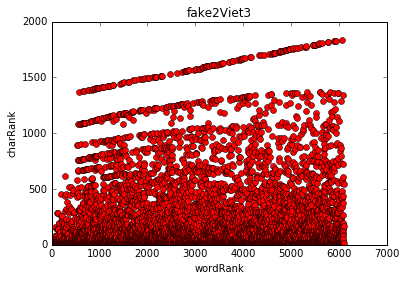

In [17]:
draw(big,feature = "0th_char_rank",log = False, x_label = "wordRank", y_label = "charRank", title = "fake2Viet3")

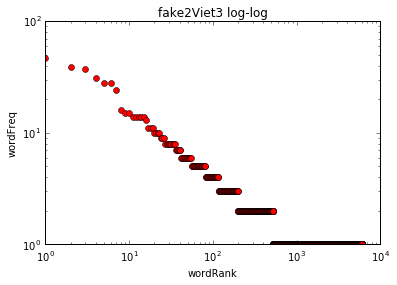

In [18]:
draw(big,feature = "wordFreq",log = True, x_label = "wordRank", y_label = "wordFreq", title = "fake2Viet3 log-log")

Read file successfully!
Successfully count word freqency!
Successfully count char freqency!
Successfully build data frames!
wordRank  ratio:  [ 0.02806077  0.39490446  0.64516129  0.625       0.56        0.78571429]
std=  0.24339601805


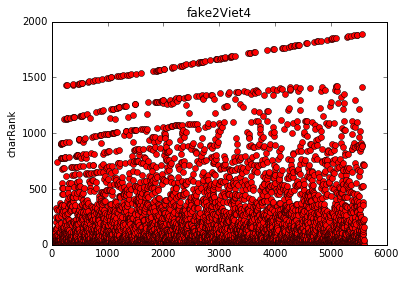

In [19]:
#encode = "UTF-16" #(1)
encode = "UTF-8"   #(2)
##if anything goes into trouble, use (1) instead of (2), and vise versa.
filename = "fake2char_Viet4.txt" #change filename when you want to get statictical information of another
##text file.
big, char, word = main(filename,encode) 
check_const_ratio(word,feature= "wordRank", criteria = "wordFreq",max_range = 200)
draw(big,feature = "0th_char_rank",log = False, x_label = "wordRank", y_label = "charRank", title = "fake2Viet4")


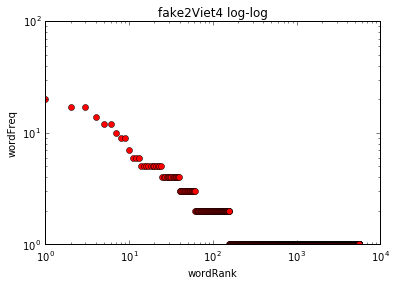

In [20]:
draw(big,feature = "wordFreq",log = True, x_label = "wordRank", y_label = "wordFreq", title = "fake2Viet4 log-log")

Read file successfully!
Successfully count word freqency!
Successfully count char freqency!
Successfully build data frames!


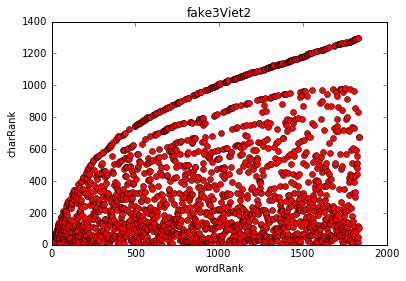

In [21]:
#encode = "UTF-16" #(1)
encode = "UTF-8"   #(2)
##if anything goes into trouble, use (1) instead of (2), and vise versa.
filename = "fake3char_Viet2.txt" #change filename when you want to get statictical information of another
##text file.
big, char, word = main(filename,encode) 
draw(big,feature = "0th_char_rank",log = False, x_label = "wordRank", y_label = "charRank", title = "fake3Viet2")

In [22]:
check_const_ratio(word,feature= "wordRank", criteria = "wordFreq",max_range = 200)

wordRank  ratio:  [ 0.51742919  0.60421053  0.68815331  0.7721519   0.78688525  0.86666667
  0.86057692  0.82122905  0.88435374  0.9         0.92307692  0.90740741
  0.96938776  0.93684211  0.94382022  0.92857143  0.8974359   0.95714286
  0.97014925  0.92307692  0.93333333  0.91071429  0.94117647  0.97916667
  0.93617021  0.95454545  0.95238095  0.95      ]
std=  0.110477038576


array([  1.83600000e+03,   5.17429194e-01,   6.04210526e-01,
         6.88153310e-01,   7.72151899e-01,   7.86885246e-01,
         8.66666667e-01,   8.60576923e-01,   8.21229050e-01,
         8.84353741e-01,   9.00000000e-01,   9.23076923e-01,
         9.07407407e-01,   9.69387755e-01,   9.36842105e-01,
         9.43820225e-01,   9.28571429e-01,   8.97435897e-01,
         9.57142857e-01,   9.70149254e-01,   9.23076923e-01,
         9.33333333e-01,   9.10714286e-01,   9.41176471e-01,
         9.79166667e-01,   9.36170213e-01,   9.54545455e-01,
         9.52380952e-01,   9.50000000e-01,   2.63157895e-02])

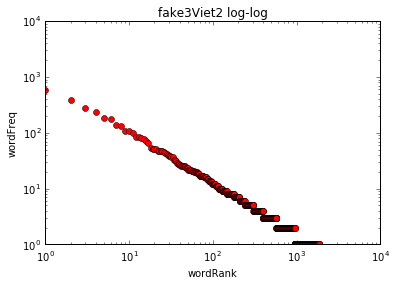

In [23]:
draw(big,feature = "wordFreq",log = True, x_label = "wordRank", y_label = "wordFreq", title = "fake3Viet2 log-log")

Read file successfully!
Successfully count word freqency!
Successfully count char freqency!
Successfully build data frames!
wordRank  ratio:  [ 0.27023945  0.48101266  0.64473684  0.7414966   0.78899083  0.8255814
  0.83098592  0.94915254  0.80357143  0.95555556  0.86046512  0.89189189
  0.87878788  0.96551724]
std=  0.188389945586


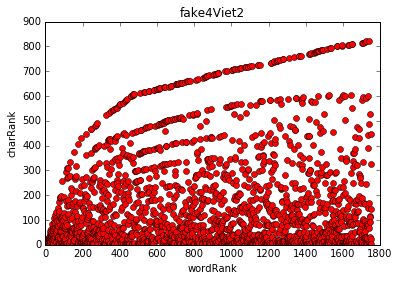

In [24]:
#encode = "UTF-16" #(1)
encode = "UTF-8"   #(2)
##if anything goes into trouble, use (1) instead of (2), and vise versa.
filename = "fake4char_Viet2.txt" #change filename when you want to get statictical information of another
##text file.
big, char, word = main(filename,encode) 
check_const_ratio(word,feature= "wordRank", criteria = "wordFreq",max_range = 200)
draw(big,feature = "0th_char_rank",log = False, x_label = "wordRank", y_label = "charRank", title = "fake4Viet2")

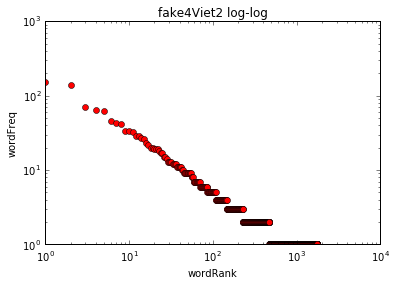

In [25]:
draw(big,feature = "wordFreq",log = True, x_label = "wordRank", y_label = "wordFreq", title = "fake4Viet2 log-log")